# Analysis of [Exp Name]
## Performed [Date]
* Shift-up analysis with stitched cells

### Load modules

In [1]:
from __future__ import division

# import modules
import sys
import os
from pprint import pprint # for human readable file output
import cPickle as pickle
import numpy as np

# load mm3 modules, always reload the plotting modules
%load_ext autoreload
%autoreload 2
sys.path.insert(0, '/Users/jt/drive/code/mm3/') # path to mm3 folder
import mm3_helpers as mm3
%aimport mm3_plots

# plotting modules and settings. 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.25)

//anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
:0: FutureWarning: IPython widgets are experimental and may change in the future.


### Load experimental data and parameters

In [2]:
# experimental parameters
param_file_path = '../../params.yaml'
params = mm3.init_mm3_helpers(param_file_path)

# load specs file, indicating which channels have cells
with open('../specs.pkl', 'r') as specs_file:
    specs = pickle.load(specs_file)
    
# nominal time to absolute time map
with open('../time_table.pkl', 'r') as time_table_file:
    time_table = pickle.load(time_table_file)
    
# load segmented cell data dict
with open('./complete_cells.pkl', 'r') as cell_file:
    Complete_Cells = pickle.load(cell_file)

In [8]:
# picture taking interval in minutes
time_int = 

# shift time, the timepoint, not the actual minute
shift_t = 

# used for coloring single traces
tif_width = 

## Filter cells
* Only look at mother cells.
* Only consider continuous lineages that span certain timepoints.

In [44]:
# limit to continuous lineages born between these two times
t1 = shift_t - 200
t2 = shift_t + 500

Cells = Complete_Cells.copy()
Cells = mm3_plots.find_cells_of_birth_label(Cells, label_num=1)
# Cells = mm3_plots.find_cells_born_after(Cells, born_after=t1)
# Cells = mm3_plots.find_cells_born_before(Cells, born_before=t2)
# Cells = mm3_plots.filter_by_stat(Cells, center_stat='mean', std_distance=3)
Lineages = mm3_plots.organize_cells_by_channel(Cells, specs)
Lineages = mm3_plots.find_continuous_lineages(Lineages, t1=t1, t2=t2)
Cells = mm3_plots.lineages_to_dict(Lineages)

# number of cells
n = len(Cells)
print('There are {} Cells'.format(n))

# tell us how many cells we have
n_fovs = 0
n_peaks = 0 
n_cells = 0
for fov, peaks in Lineages.iteritems():
    n_fovs += 1
    for peak, lin in peaks.iteritems():
        n_peaks += 1
        for cell_id, cell in lin.iteritems():
            n_cells += 1

print('There are {} FOVs, {} channels, and {} mother cells.'.format(n_fovs, n_peaks, n_cells))

There are 1178 Cells
There are 28 FOVs, 80 channels, and 1178 mother cells.


### Save filtered cells

In [6]:
# with open(os.path.join(params['cell_dir'],'mother_cells.pkl'), 'wb') as cell_file:
#     pickle.dump(Cells, cell_file, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open(os.path.join(params['cell_dir'], 'continuous_lineages.pkl'), 'wb') as cell_file:
#     pickle.dump(Lineages, cell_

# from scipy.io import savemat
# with open(os.path.join(params['cell_dir'], 'cells.mat', 'wb') as cell_file:
#     savemat(cell_file, Cells)

## Stitch mother cells
* Here we want to turn the continuous lineages into a continually growing cells. We can equivalently use log addition or multiplication of each subsequent cell by the length at the previous length before division.
* Note that the division time of one cell is the birth time of the daughter cell, so those lengths should natually be conincident except when the septum position deviates from 0.5. For this reason the division point of cells is ignored to avoid double counting that data.

### Stitching via log addition

In [46]:
# and this dictionary will carry times and lengths for each lineage
lineage_lengths = {}

# go through the cells organized by fov, channel
for fov, peak in Lineages.iteritems():
    # create nested dict for this FOV
    lineage_lengths[fov] = {}

    for peak, lin in peak.iteritems():
        # sort the cells by birth time
        lin = [(cell_id, cell) for cell_id, cell in lin.iteritems()]
        lin = sorted(lin, key=lambda x: x[1].birth_time)

        # initialize arrays for this cell's information
        lin_times = np.array([])
        lin_lengths = np.array([])

        # initialize offset. Use first length
        offset = 0

        # create the cumulative times and lengths. 
        for i, cell_tuple in enumerate(lin):
            # add the times to the list
            current_times = np.round(np.array(cell_tuple[1].abs_times[:-1]) / 60.0)
            lin_times = np.concatenate((lin_times, current_times))

            # update lengths to reflect true size in um
            current_lengths = np.array(cell_tuple[1].lengths) * params['pxl2um']

            # update offset to take into account first length (not on first time)
            if i != 0:
                offset -= np.log(current_lengths[0])

            # offset new length values 
            new_lengths = np.log(current_lengths) + offset

            # add them to the big list
            lin_lengths = np.concatenate((lin_lengths, new_lengths))

            # update offset to reflect the previous division length
            offset = lin_lengths[-1]
           
            # this dictionary holds all the times, lengths, and derivatives
            lineage_lengths[fov][peak] = {'times' : lin_times - shift_t,
                                          'log_lengths' : lin_lengths}

### Plot

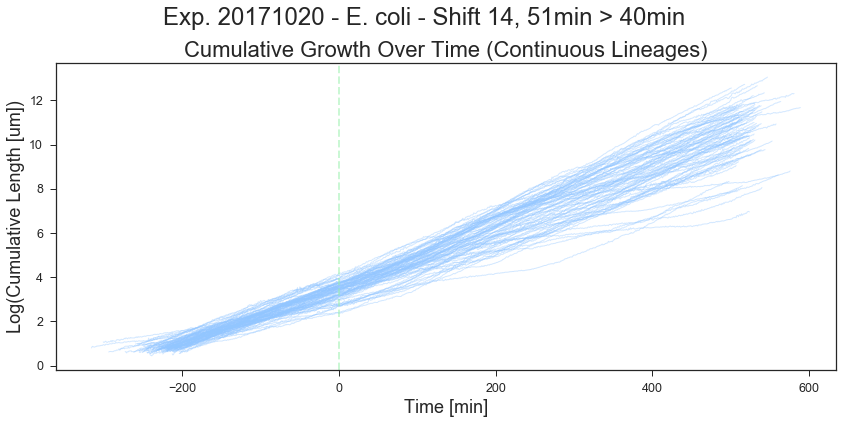

In [47]:
sns.set(style="ticks", palette="pastel", color_codes=True, font_scale=1.25)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
ax = [axes]

for fov, peaks in lineage_lengths.items():
    for peak, data in peaks.items():        
        # plot cumulative log(length)
        ax[0].plot(data['times'], data['log_lengths'], c='b', lw=1, alpha=0.4, 
                   label='Cumulative log length')

# vertical lines for shift up time
ax[0].axvline(x=0, linewidth=2, color='g', ls='--', alpha=0.5, label='Shift-up time')

# format plot
ax[0].set_title('Cumulative Growth Over Time (Continuous Lineages)', size=22)
ax[0].set_ylabel('Log(Cumulative Length [um])', size=18)
ax[0].set_xlabel('Time [min]', size=18)
plt.tight_layout()
fig.suptitle('Exp. 20171020 - E. coli - Shift 14, 51min > 40min', size=24)
plt.subplots_adjust(top=0.85, hspace=0.1)    
plt.show()

### Stitching via multiplication

In [48]:
# This dictionary will carry times and lengths for each lineage
lineage_lengths = {}

for fov, peak in Lineages.iteritems():

    lineage_lengths[fov] = {}

    for peak, lin in peak.iteritems():
        # sort the cells by birth time
        lin = [(cell_id, cell) for cell_id, cell in lin.iteritems()]
        lin = sorted(lin, key=lambda x: x[1].birth_time)

        lin_times = np.array([])
        lin_lengths = np.array([])

        # initialize factor multiplication
        factor = 1

        # create the cumulative times and lengths. 
        for i, cell_tuple in enumerate(lin):
            # add the times to the list
            current_times = np.array(cell_tuple[1].abs_times[:-1])
            lin_times = np.concatenate((lin_times, current_times))

            # update lengths to reflect true size in um
            current_lengths = np.array(cell_tuple[1].lengths).astype('float64') * params['pxl2um']
            
            # calculate factor difference between last length and this length
            # don't do it on the first go
            if i != 0:
                factor = lin_lengths[-1] / current_lengths[0]
                
            # update lengths 
            current_lengths *= factor

            # add them to the big list
            lin_lengths = np.concatenate((lin_lengths, current_lengths))

            # update offset to reflect the previous division length
            factor = current_lengths / cell_tuple[1].septum_position

        # this dictionary holds all the times, lengths, and derivatives
        lineage_lengths[fov][peak] = {'times' : lin_times,
                                      'times_min' : lin_times / 60.0 - shift_t,
                                      'times_min_bin' : np.round(lin_times / 60.0) - shift_t,
                                      'lengths' : lin_lengths,
                                      'log_lengths' : np.log(lin_lengths)}


### Plot

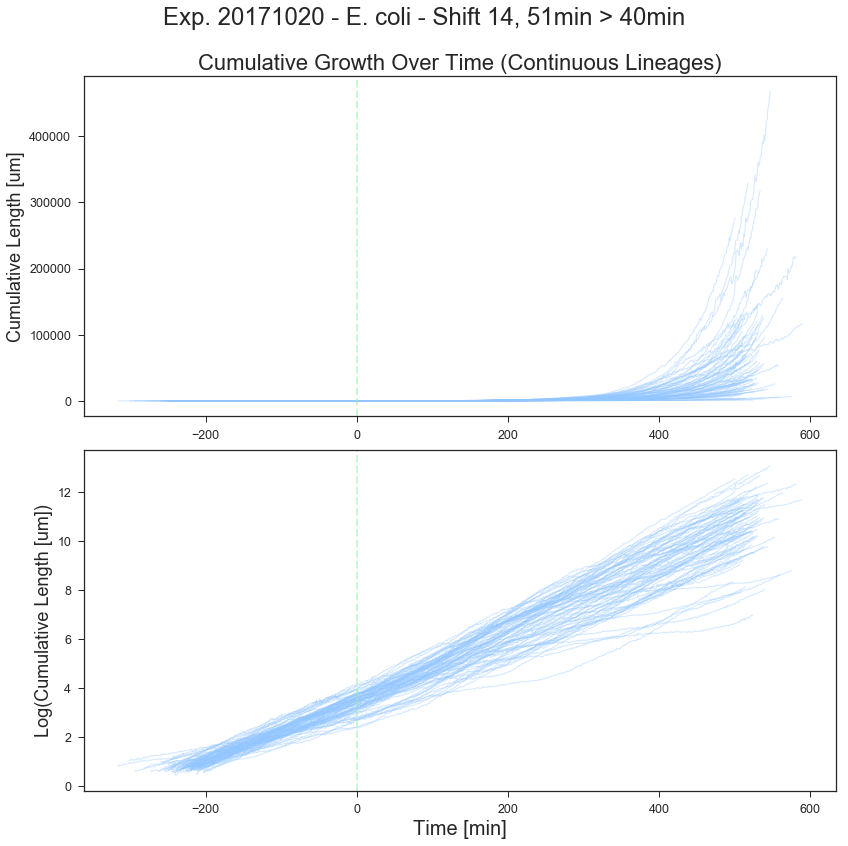

In [49]:
sns.set(style="ticks", palette="pastel", color_codes=True, font_scale=1.25)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

ax = axes.flat

for fov, peaks in lineage_lengths.items():
    for peak, data in peaks.items():        
        # plot cumulative length and log(cumulative length)
        ax[0].plot(data['times_min'], data['lengths'], c='b', lw=1, alpha=0.4, 
                   label='Cumulative length')
        
        ax[1].plot(data['times_min'], data['log_lengths'], c='b', lw=1, alpha=0.4, 
                   label='Cumulative log length')

# vertical lines for shift up time
ax[0].axvline(x=0, linewidth=2, color='g', ls='--', alpha=0.5, label='Shift-up time')
ax[1].axvline(x=0, linewidth=2, color='g', ls='--', alpha=0.5, label='Shift-up time')

# format plot
ax[0].set_title('Cumulative Growth Over Time (Continuous Lineages)', size=22)
ax[0].set_ylabel('Cumulative Length [um]', size=18)
# ax[0].set_xlim([0, 200])
# ax[0].set_ylim([0, 2000])
ax[1].set_ylabel('Log(Cumulative Length [um])', size=18)
ax[1].set_xlabel('Time [min]', size=20)
plt.subplots_adjust(hspace=0.6)
plt.tight_layout()
fig.suptitle('Exp. 20171020 - E. coli - Shift 14, 51min > 40min', size=24)
plt.subplots_adjust(top=0.9, hspace=0.1)    

plt.show()

## Explore the data
* The two stitching methods are equivalent as is apparent from the graph above. We will use the data from the latter going forward.

### The lineages are organized by FOV and peak (channel number)

In [50]:
for fov, peak in lineage_lengths.iteritems():
    print(fov, peak.keys())

(1, [848, 1362])
(2, [480, 553, 773, 847])
(3, [769, 108, 182])
(4, [185, 1138, 111, 991])
(5, [403, 475])
(6, [185, 626, 1067, 1141])
(7, [1065, 1212, 110, 918])
(8, [915, 182])
(9, [108])
(10, [1061])
(11, [844, 1212, 991])
(12, [1137, 404, 917])
(13, [1432, 1209, 843, 403])
(14, [401, 108, 1061, 1430, 181])
(15, [769, 842])
(16, [108, 254])
(17, [1059, 620, 1278])
(18, [986, 1133])
(19, [330])
(20, [1208, 1354, 402, 183])
(21, [327, 1059, 839, 107, 913, 693, 1279])
(22, [620, 1132, 1206, 767])
(23, [332])
(24, [1282, 477])
(25, [769, 1062])
(27, [696])
(29, [408, 261, 1214])
(30, [842, 1429, 622, 1135])


### Show the first 100 time points and lengths for one lineages
* Note that the time doesn't always fall on the minute.

In [51]:
pprint(lineage_lengths[2][847]['times_min'][:100])
pprint(lineage_lengths[2][847]['lengths'][:100])

array([-248.98333333, -247.98333333, -246.98333333, -245.98333333,
       -244.98333333, -243.96666667, -242.98333333, -241.98333333,
       -240.98333333, -239.96666667, -238.98333333, -237.96666667,
       -236.98333333, -235.98333333, -234.98333333, -233.98333333,
       -232.98333333, -231.98333333, -230.98333333, -229.98333333,
       -228.98333333, -227.98333333, -226.98333333, -225.98333333,
       -224.98333333, -223.96666667, -222.98333333, -221.98333333,
       -220.98333333, -219.98333333, -218.98333333, -217.98333333,
       -216.98333333, -215.98333333, -214.98333333, -213.98333333,
       -212.98333333, -211.98333333, -210.98333333, -209.98333333,
       -208.98333333, -207.98333333, -206.98333333, -205.98333333,
       -204.98333333, -203.98333333, -202.98333333, -201.98333333,
       -200.98333333, -199.98333333, -198.98333333, -197.98333333,
       -196.98333333, -195.98333333, -194.98333333, -193.98333333,
       -192.98333333, -191.98333333, -190.98333333, -189.98333

## Calculate cumulative growth rate for each lineage
* We want to calculate the growth rate from stitched cell lengths from time zero to every time point
* We will then average growth rates by time point

In [52]:
# go through every stitched lineage
for fov, peaks in lineage_lengths.iteritems():
    for peak in peaks.keys():
        # get initial length and time and arrays for convenience
        init_length = lineage_lengths[fov][peak]['lengths'][0]
        lengths = lineage_lengths[fov][peak]['lengths']
        init_time = lineage_lengths[fov][peak]['times'][0]
        times = lineage_lengths[fov][peak]['times']
        
        # initialize array for mus
        mus = np.array([])
        
        # go through all time points and calculate growth rate
        for i, t in enumerate(times):
            
            # skip first time point
            if i == 0:
                continue
        
            # calculate inst. growth rate mu
            mu = np.log(lengths[i] / init_length) / (t - init_time)
            
            # convert to 1/hours for legibility (in seconds currently)
            mu *= 3600
            
            # append to big list
            mus = np.append(mus, mu)
        
        # put data in dictionary
        lineage_lengths[fov][peak]['mus'] = mus
        lineage_lengths[fov][peak]['mu_times'] = times[:-1]
        # round the times to the closest minute for binning later
        mu_times_min = np.round(times[:-1] / 60.0) - shift_t 
        lineage_lengths[fov][peak]['mu_times_min'] = mu_times_min

In [53]:
pprint(lineage_lengths[2][847]['mu_times_min'][:100])

array([-249., -248., -247., -246., -245., -244., -243., -242., -241.,
       -240., -239., -238., -237., -236., -235., -234., -233., -232.,
       -231., -230., -229., -228., -227., -226., -225., -224., -223.,
       -222., -221., -220., -219., -218., -217., -216., -215., -214.,
       -213., -212., -211., -210., -209., -208., -207., -206., -205.,
       -204., -203., -202., -201., -200., -199., -198., -197., -196.,
       -195., -194., -193., -192., -191., -190., -189., -188., -187.,
       -186., -185., -184., -183., -182., -181., -180., -179., -178.,
       -177., -176., -175., -174., -173., -172., -171., -170., -169.,
       -168., -167., -166., -165., -164., -163., -162., -161., -160.,
       -159., -158., -157., -156., -155., -154., -153., -152., -151., -150.])


## Plot a few individual traces
* See how there are natural fluctuations. We need to average across traces to see if there is a conserved trend

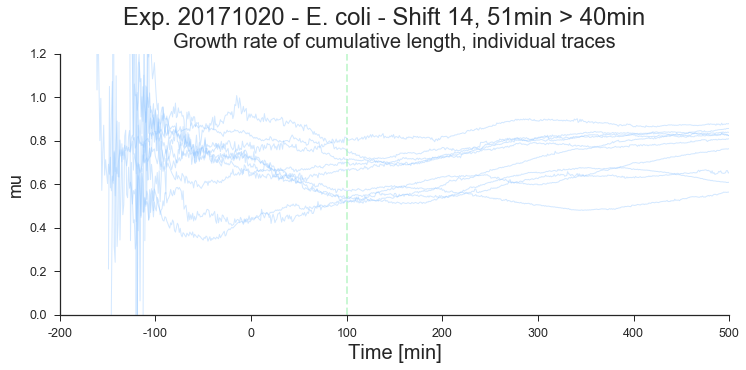

In [54]:
sns.set(style="ticks", palette="pastel", color_codes=True, font_scale=1.25)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))
ax = [axes]

n_traces = 0
row_i = 0
for fov, peaks in lineage_lengths.items():
    for peak, data in peaks.items():        
        # plot cumulative length and log(cumulative length)
        ax[0].plot(data['mu_times_min'], data['mus'], c='b', lw=1, alpha=0.4, 
                   label='Cumulative length')

        # only plot 10 traces
        n_traces += 1
        if n_traces >= 10: 
            break
    if n_traces >= 10:
        break
        
# shift up time
ax[0].axvline(x=0, linewidth=2, color='g', ls='--', alpha=0.5, label='Shift-up time')

# format plot
ax[0].set_title('Growth rate of cumulative length, individual traces', size=20)
for axis in ax:
    axis.set_xlim([-300, 400])
    axis.set_xticklabels([])
    axis.set_ylim([0, 1.2])
    axis.set_ylabel('mu', size=18)
ax[0].set_xlabel('Time [min]', size=20)
ax[0].set_xticklabels([-200, -100, 0, 100, 200, 300, 400, 500])
sns.despine() 
fig.suptitle('Exp. 20171020 - E. coli - Shift 14, 51min > 40min', size=24)
plt.subplots_adjust(top=0.85)
plt.show()

## Average by time point
* At each minute, average the the growth rate for that bin across the population. 

In [55]:
# dictionary holds data by timepoint and then averages. 
cum_stats_by_time = {'mus_by_time' : {},
                     'times_w_avg' : []}

# group the mus from above by time point
for fov, peaks in lineage_lengths.iteritems():
    for peak, data in peaks.iteritems():
        for i, t in enumerate(data['mu_times_min']):
            # append data to correct time point slot, or make slot
            if t in cum_stats_by_time['mus_by_time']:
                cum_stats_by_time['mus_by_time'][t].append(data['mus'][i])
            else:
                cum_stats_by_time['mus_by_time'][t] = [data['mus'][i]]

# average the mu per time point
for time, values in cum_stats_by_time['mus_by_time'].iteritems():
    cum_stats_by_time['times_w_avg'].append((time, np.mean(values)))
    
# sort the times and averages and store in their own lists in dict
cum_stats_by_time['times_w_avg'] = sorted(cum_stats_by_time['times_w_avg'])
cum_stats_by_time['times'], cum_stats_by_time['mus_avg'] = zip(*cum_stats_by_time['times_w_avg'])

In [56]:
pprint(cum_stats_by_time['times'][:10])
pprint(cum_stats_by_time['mus_avg'][:10])

(-316.0,
 -315.0,
 -313.0,
 -312.0,
 -311.0,
 -310.0,
 -309.0,
 -308.0,
 -307.0,
 -306.0)
(4.768591155164053,
 0.91217760828056982,
 0.5597317557932675,
 0.68427883083934937,
 0.65106541601579948,
 0.79662571285887485,
 0.59612332926628664,
 0.61693570243957974,
 0.54701632282976076,
 0.53000095736580355)


### Plot

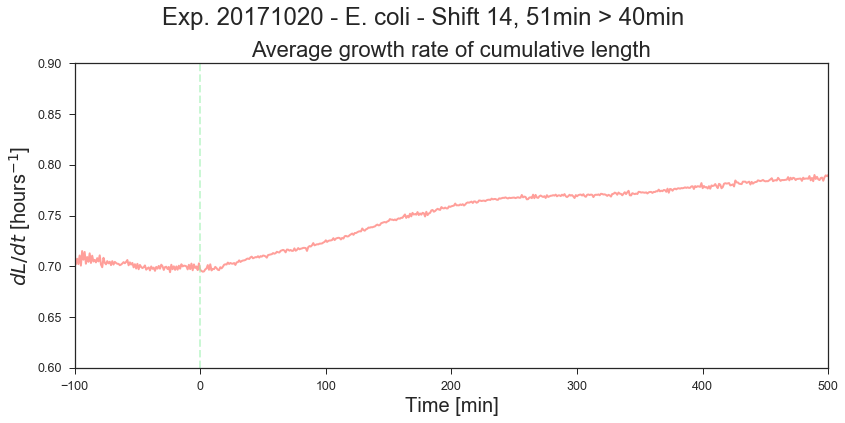

In [57]:
sns.set(style="ticks", palette="pastel", color_codes=True, font_scale=1.25)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
  
# plot average and standard deviation of the rate of change.
ax.plot(cum_stats_by_time['times'], 
        cum_stats_by_time['mus_avg'], 
        c='r', lw=2, alpha=1, label='Average rate of change')

# vertical lines for shift up time
ax.axvline(x=0, linewidth=2, color='g', ls='--', alpha=0.5, label='Shift-up time')

# format plot
ax.set_xlim([-100, +500])
ax.set_ylim([0.6, 0.9])
ax.set_title('Average growth rate of cumulative length', size=22)
ax.set_ylabel('$dL/dt$ [hours$^{-1}$]', size=20)
ax.set_xlabel('Time [min]', size=20)
plt.tight_layout()
fig.suptitle('Exp. 20171020 - E. coli - Shift 14, 51min > 40min', size=24)
plt.subplots_adjust(top=0.85)
plt.show()

* The data looks noisy before the shift up time because alternating timepoints have different ammounts of data (i.e. because data was binned to the minute, and the picture interval was not constant due florescent imaging on odd intervals, some minutes have more data than others). This worked itself out after the shift when the experiment was paused briefly. 
* In either case, there does not seem to be any oscillation due to shift up.

## Calculate growth rate over a moving window
* In this case, we will caculate the instanteous growth rate over a moving window, still using the cumulative cell lengths

In [58]:
# This dictionary carries all the lengths by time point, and rate of change by timepoint
stats_by_time = {'diffs_by_time' : {}, 
                 'times' : [],
                 'diff_means' : [],
                 'diff_stds' : [],
                 'diff_SE' : [],
                 'diff_n' : []}

# we loop through each cell to find the rate of length change
for fov, peaks in lineage_lengths.iteritems():
    for peak, data in peaks.iteritems():

        # pull out times and lengthts for convenience
        lengths = data['lengths']
        times = data['times']

        # find growth rate over this many time points. 
        n_diff = 10

        # log of of scaled length
        lengths_diff = [np.log(lengths[i+n_diff] / l) for i, l in enumerate(lengths[:-n_diff])]
        
        # difference in time 
        diff_steps = [times[i+n_diff] - t for i, t in enumerate(times[:-n_diff])]

        # divide
        lengths_diff = np.divide(lengths_diff, diff_steps)
        
        # convert to hours (currently in minutes)
        lengths_diff *= 3600

        # convert corresponding times, bin to the minute
        diff_times = np.round(times[:-n_diff] / 60.0) - shift_t

        # add data to time point centric dictionary 
        for i, t in enumerate(diff_times):
            if t in stats_by_time['diffs_by_time']:
                stats_by_time['diffs_by_time'][t].append(lengths_diff[i])
            else:
                stats_by_time['diffs_by_time'][t] = [lengths_diff[i]]
        
# calculate timepoint by timepoint stats
times_and_values = sorted(stats_by_time['diffs_by_time'].items())

for t, values in times_and_values:
    stats_by_time['times'].append(t)
    stats_by_time['diff_means'].append(np.mean(values))
    stats_by_time['diff_stds'].append(np.std(values))
    stats_by_time['diff_SE'].append(np.std(values) / np.sqrt(len(values)))
    stats_by_time['diff_n'].append(len(values))

In [59]:
pprint(stats_by_time['times'][:10])
pprint(stats_by_time['diff_means'][:10])

[-316.0,
 -315.0,
 -313.0,
 -312.0,
 -311.0,
 -310.0,
 -309.0,
 -308.0,
 -307.0,
 -306.0]
[0.53000095736580355,
 0.22803094522316586,
 0.41292088853329806,
 0.47538779980976636,
 0.54695210168066555,
 0.46214480765477667,
 0.15240475255728375,
 0.49766943423327453,
 0.45069102447506476,
 0.42684037419288795]


### Plot

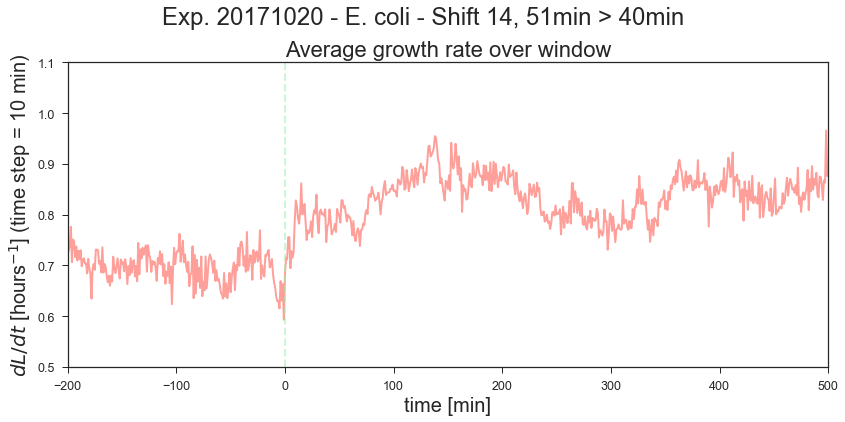

In [60]:
sns.set(style="ticks", palette="pastel", color_codes=True, font_scale=1.25)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
  
# plot average and standard deviation of the rate of change.
ax.plot(stats_by_time['times'], stats_by_time['diff_means'], c='r', lw=2, alpha=1, 
        label='Average rate of change')

# vertical lines for shift up time
ax.axvline(x=0, linewidth=2, color='g', ls='--', alpha=0.5, label='Shift-up time')

# format plot
ax.set_xlim([-200, +500])
ax.set_ylim([0.5, 1.1])
ax.set_title('Average growth rate over window', size=22)
ax.set_ylabel('$dL/dt$ [hours$^{-1}$] (time step = %d min)' % (n_diff), size=20)
ax.set_xlabel('time [min]', size=20)
# ax.legend(loc='lower right', fontsize=16)

plt.tight_layout()
fig.suptitle('Exp. 20171020 - E. coli - Shift 14, 51min > 40min', size=24)
plt.subplots_adjust(top=0.85)
    
plt.show()

* So this is what I don't understand, because with the sliding window I see a definitive overshoot in growth rate.

## Using all cells growth rate calculation
* The above data just focuses on cells from continuous lineages. This is a requirement for the cumulative growth rate from the stitched cells, but not for the second method that uses the sliding window. 

### Refilter cells
* Use all cells with birth label 1 and 2 (mothers and sisters)

In [61]:
# limit to continuous lineages born between these two times
Cells = Complete_Cells.copy()
Cells = mm3_plots.find_cells_of_birth_label(Cells, label_num=[1, 2])
Cells = mm3_plots.filter_by_stat(Cells, center_stat='mean', std_distance=3)

# number of cells
n = len(Cells)
print('There are {} Cells'.format(n))

There are 22603 Cells


### Same analysis as above, but done in a cell centric manner.
* Elongation rates between cells is not considerederd. 
* Elongation rate is still averaged per time point.

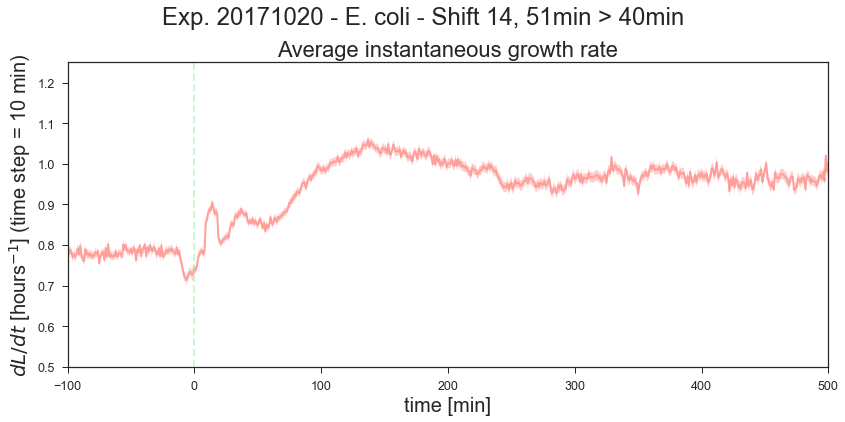

In [62]:
# This dictionary carries all the lengths by time point, and rate of change by timepoint
stats_by_time = {'diffs_by_time' : {}, 
                 'times' : [],
                 'diff_means' : [],
                 'diff_stds' : [],
                 'diff_SE' : [],
                 'diff_n' : []}

# we loop through each cell to find the rate of length change
for cell_id, Cell in Cells.items():

    # convert lengths to um from pixels
    lengths = np.array(Cell.lengths_w_div)
    times = np.array(Cell.abs_times)

    # take numerical n-step 1st derivative 
    n_diff = 10
    
    lengths_diff = [np.log(lengths[i+n_diff] / l) for i, l in enumerate(lengths[:-n_diff])]
    diff_steps = [times[i+n_diff] - t for i, t in enumerate(times[:-n_diff])]
    lengths_diff = np.divide(lengths_diff, diff_steps)
    lengths_diff *= 3600

    # convert corresponding times, bin to the minute
    diff_times = np.round(times[:-n_diff] / 60.0) - shift_t
    
    # add data to time point centric dictionary 
    for i, t in enumerate(diff_times):
        if t in stats_by_time['diffs_by_time']:
            stats_by_time['diffs_by_time'][t].append(lengths_diff[i])
        else:
            stats_by_time['diffs_by_time'][t] = [lengths_diff[i]]
        
# calculate timepoint by timepoint stats
times_and_values = sorted(stats_by_time['diffs_by_time'].items())

for t, values in times_and_values:
    stats_by_time['times'].append(t)
    stats_by_time['diff_means'].append(np.mean(values))
    stats_by_time['diff_stds'].append(np.std(values))
    stats_by_time['diff_SE'].append(np.std(values) / np.sqrt(len(values)))
    stats_by_time['diff_n'].append(len(values))

### plot
sns.set(style="ticks", palette="pastel", color_codes=True, font_scale=1.25)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
  
# plot average and standard deviation of the rate of change.
ax.plot(stats_by_time['times'], stats_by_time['diff_means'], c='r', lw=2, alpha=1, 
          label='Average rate of change')
ax.fill_between(stats_by_time['times'], 
                np.array(stats_by_time['diff_means']) - np.array(stats_by_time['diff_SE']), 
                np.array(stats_by_time['diff_means']) + np.array(stats_by_time['diff_SE']),
                facecolor='r', alpha=0.5)

# vertical lines for shift up time
ax.axvline(x=0, linewidth=2, color='g', ls='--', alpha=0.5, label='Shift-up time')

# format plot
ax.set_xlim([-100, +500])
ax.set_ylim([0.5, 1.25])
ax.set_title('Average instantaneous growth rate', size=22)
ax.set_ylabel('$dL/dt$ [hours$^{-1}$] (time step = %d min)' % (n_diff), size=20)
ax.set_xlabel('time [min]', size=20)
plt.tight_layout()
fig.suptitle('Exp. 20171020 - E. coli - Shift 14, 51min > 40min', size=24)
plt.subplots_adjust(top=0.85)
plt.show()

## Alternative: average lineages first and then find growth rate
* Here, we average the lengths by time point first, and then find the growth rate either cumulative from the start, or with a sliding window

### Average across cumulative lengths by time point

In [63]:
# dictionary holds data by timepoint and then averages. 
avg_length_by_time = {'lengths_by_time' : {},
                      'times_w_avg' : []}

# group the mus from above by time point
for fov, peaks in lineage_lengths.iteritems():
    for peak, data in peaks.iteritems():
        for i, t in enumerate(data['times_min_bin']):
            # append data to correct time point slot, or make slot
            if t in avg_length_by_time['lengths_by_time']:
                avg_length_by_time['lengths_by_time'][t].append(data['lengths'][i])
            else:
                avg_length_by_time['lengths_by_time'][t] = [data['lengths'][i]]

# average the mu per time point
for time, values in avg_length_by_time['lengths_by_time'].iteritems():
    avg_length_by_time['times_w_avg'].append((time, np.mean(values)))
    
# sort the times and averages and store in their own lists in dict
avg_length_by_time['times_w_avg'] = sorted(avg_length_by_time['times_w_avg'])
avg_length_by_time['times'], avg_length_by_time['length_avgs'] = zip(*avg_length_by_time['times_w_avg'])

### Plot

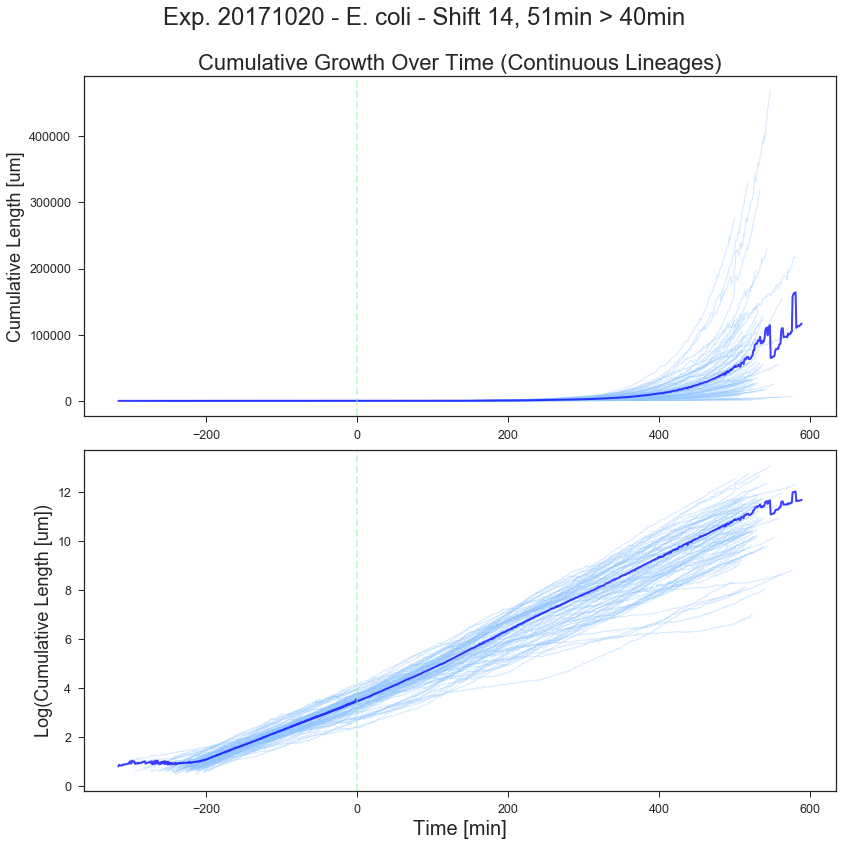

In [64]:
sns.set(style="ticks", palette="pastel", color_codes=True, font_scale=1.25)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

ax = axes.flat

for fov, peaks in lineage_lengths.items():
    for peak, data in peaks.items():        
        # plot cumulative length and log(cumulative length)
        ax[0].plot(data['times_min'], data['lengths'], c='b', lw=1, alpha=0.4, 
                   label='Cumulative length')
        
        ax[1].plot(data['times_min'], data['log_lengths'], c='b', lw=1, alpha=0.4, 
                   label='Cumulative log length')
        
# average
ax[0].plot(avg_length_by_time['times'], avg_length_by_time['length_avgs'], 
           c='blue', lw=2, alpha=0.75)
ax[1].plot(avg_length_by_time['times'], np.log(avg_length_by_time['length_avgs']), 
           c='blue', lw=2, alpha=0.75)

# vertical lines for shift up time
ax[0].axvline(x=0, linewidth=2, color='g', ls='--', alpha=0.5, label='Shift-up time')
ax[1].axvline(x=0, linewidth=2, color='g', ls='--', alpha=0.5, label='Shift-up time')

# format plot
ax[0].set_title('Cumulative Growth Over Time (Continuous Lineages)', size=22)
ax[0].set_ylabel('Cumulative Length [um]', size=18)
# ax[0].set_xlim([0, 200])
# ax[0].set_ylim([0, 2000])
ax[1].set_ylabel('Log(Cumulative Length [um])', size=18)
ax[1].set_xlabel('Time [min]', size=20)
plt.subplots_adjust(hspace=0.6)
plt.tight_layout()
fig.suptitle('Exp. 20171020 - E. coli - Shift 14, 51min > 40min', size=24)
plt.subplots_adjust(top=0.9, hspace=0.1)    

plt.show()

### cumulative and instant growth rate for average cumulative length

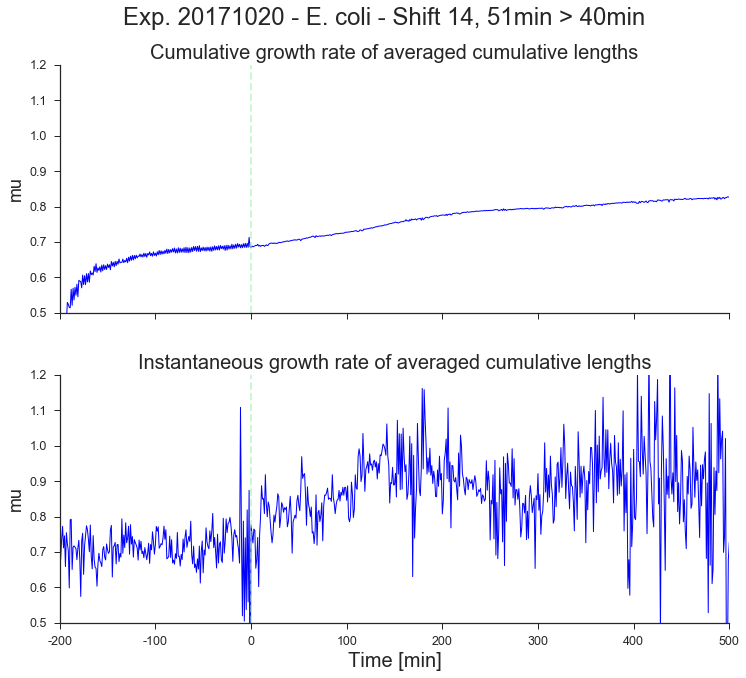

In [65]:
# get initial length and time and arrays for convenience
# truncate off the first 100 data points as they are noisy
init_length = avg_length_by_time['length_avgs'][100]
lengths = avg_length_by_time['length_avgs'][100:]
init_time = avg_length_by_time['times'][100]
times = avg_length_by_time['times'][100:]

# initialize array for mus
mus_cum = np.array([])

# go through all time points and calculate growth rate
for i, t in enumerate(times):

    # skip first time point
    if i == 0:
        continue

    # calculate cum growth rate mu
    mu_cum = np.log(lengths[i] / init_length) / (t - init_time)

    # convert to 1/hours for legibility (in seconds currently)
    mu_cum *= 60

    # append to big list
    mus_cum = np.append(mus_cum, mu_cum)
    
avg_length_by_time['mus_cum'] = mus_cum
avg_length_by_time['mu_times_cum'] = times[:-1]
    
### calculuate inst. growth rate
n_diff = 10
    
# log of of scaled length
lengths_diff = [np.log(lengths[i+n_diff] / l) for i, l in enumerate(lengths[:-n_diff])]

# difference in time 
diff_steps = [times[i+n_diff] - t for i, t in enumerate(times[:-n_diff])]

# divide
lengths_diff = np.divide(lengths_diff, diff_steps)

# convert to hours (currently in minutes)
lengths_diff *= 60.0

# convert corresponding times, bin to the minute
diff_times = times[:-n_diff]

avg_length_by_time['mus_inst'] = lengths_diff
avg_length_by_time['mu_times_inst'] = diff_times

### Plot em
sns.set(style="ticks", palette="pastel", color_codes=True, font_scale=1.25)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
ax = axes.flat
    
# plot cumulative growth rate and growth rate 
ax[0].plot(avg_length_by_time['mu_times_cum'], avg_length_by_time['mus_cum'], 
           c='blue', lw=1, alpha=1)
ax[1].plot(avg_length_by_time['mu_times_inst'], avg_length_by_time['mus_inst'], 
           c='blue', lw=1, alpha=1)

# shift up time
ax[0].axvline(x=0, linewidth=2, color='g', ls='--', alpha=0.5, label='Shift-up time')
ax[1].axvline(x=0, linewidth=2, color='g', ls='--', alpha=0.5, label='Shift-up time')

# format plot
ax[0].set_title('Cumulative growth rate of averaged cumulative lengths', size=20)
ax[1].set_title('Instantaneous growth rate of averaged cumulative lengths', size=20)

for axis in ax:
    axis.set_xlim([-200, 500])
    axis.set_xticklabels([])
    axis.set_ylim([0.5, 1.2])
    axis.set_ylabel('mu', size=18)
ax[1].set_xlabel('Time [min]', size=20)
ax[1].set_xticklabels([-200, -100, 0, 100, 200, 300, 400, 500])

sns.despine() 
fig.suptitle('Exp. 20171020 - E. coli - Shift 14, 51min > 40min', size=24)
plt.subplots_adjust(top=0.90, hspace=0.25)
plt.show()

* Even though this data is more noisy, there is still the same basic descrepency.